In [24]:
# Importamos todas las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


### Carga de datos

In [25]:
# cargamos el csv como un datagrame
ruta='../data/diabetes.csv'
df = pd.read_csv(filepath_or_buffer=ruta, sep=',')
df.shape

(768, 9)

In [26]:
df.info() # obtenemos informacion del dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [27]:
df.isnull().sum() # verificamos si existen valores nulos

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Limpieza de Datos:
* Identificación y eliminación de valores duplicados: Asegúrate de que no haya registros duplicados que puedan sesgar los resultados del análisis.
* Verificación y ajuste de tipos de datos: Verifica que cada columna tenga el tipo de dato correcto (numérico o categórico) y ajusta si es necesario.
* Corrección de inconsistencias en valores categóricos: Revisa las categorías de las variables y unifica aquellos valores que puedan estar escritos de diferentes maneras pero que representen lo mismo.
* Manejo de valores faltantes adecuadamente: Identifica y maneja los valores faltantes utilizando técnicas apropiadas como la imputación de la mediana, media o moda, según corresponda.

In [28]:
df.duplicated().sum() # verificamos la existencia de valores duplicados

0

No existen valores duplicados

In [29]:
# Convertir la columna 'Outcome' a tipo categórico
df['Outcome'] = df['Outcome'].astype('category')

# Verificar el cambio
print(df.dtypes)


Pregnancies                    int64
Glucose                        int64
BloodPressure                  int64
SkinThickness                  int64
Insulin                        int64
BMI                          float64
DiabetesPedigreeFunction     float64
Age                            int64
Outcome                     category
dtype: object


In [30]:
df.isnull().sum() # identificamos si existen valores nulos

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

No existen valores faltantes, pero existen columnas que deberian tener valores superior a cero

In [31]:
# Columnas donde los valores cero no son válidos
invalid_zero_columns = [
    "Glucose",        # La glucosa no puede ser cero.
    "BloodPressure",  # La presión sanguínea no puede ser cero.
    "SkinThickness",  # El espesor de la piel no debe ser cero.
    "Insulin",        # Los valores de insulina no deberían ser cero.
    "BMI"            # El índice de masa corporal no puede ser cero.
]

In [32]:
# generamos el imputer aplicando KNNImputer
imputer = KNNImputer(n_neighbors=5) # los 5 vecinos más cercanos para imputar los valores faltantes
df[invalid_zero_columns] = imputer.fit_transform(df[invalid_zero_columns]) # aplicamos la imputación a las columnas que contienen valores inválidos

In [33]:
df[invalid_zero_columns]

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,148.0,72.0,35.0,0.0,33.6
1,85.0,66.0,29.0,0.0,26.6
2,183.0,64.0,0.0,0.0,23.3
3,89.0,66.0,23.0,94.0,28.1
4,137.0,40.0,35.0,168.0,43.1
...,...,...,...,...,...
763,101.0,76.0,48.0,180.0,32.9
764,122.0,70.0,27.0,0.0,36.8
765,121.0,72.0,23.0,112.0,26.2
766,126.0,60.0,0.0,0.0,30.1


In [34]:
# Verificamos los tipos de datos
print(df.dtypes)

Pregnancies                    int64
Glucose                      float64
BloodPressure                float64
SkinThickness                float64
Insulin                      float64
BMI                          float64
DiabetesPedigreeFunction     float64
Age                            int64
Outcome                     category
dtype: object


In [35]:
# definimos columnas numericas
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('Id', errors='ignore')
# definimos columnas categoricas
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
# mostramos las listas de columnas numericas y categoricas
print('Columnas categóricas')
print(categorical_cols)
print('\nColumnas numéricas')
print(numerical_cols)


Columnas categóricas
Index(['Outcome'], dtype='object')

Columnas numéricas
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


### Exploración de Datos:
* Visualizaciones univariadas y multivariadas: Crea histogramas, gráficos de barras, diagramas de dispersión y mapas de calor para entender la distribución y las relaciones entre las variables.
* Estadísticas descriptivas: Calcula medidas de tendencia central (media, mediana, moda) y de dispersión (rango, desviación estándar) para cada característica del dataset.

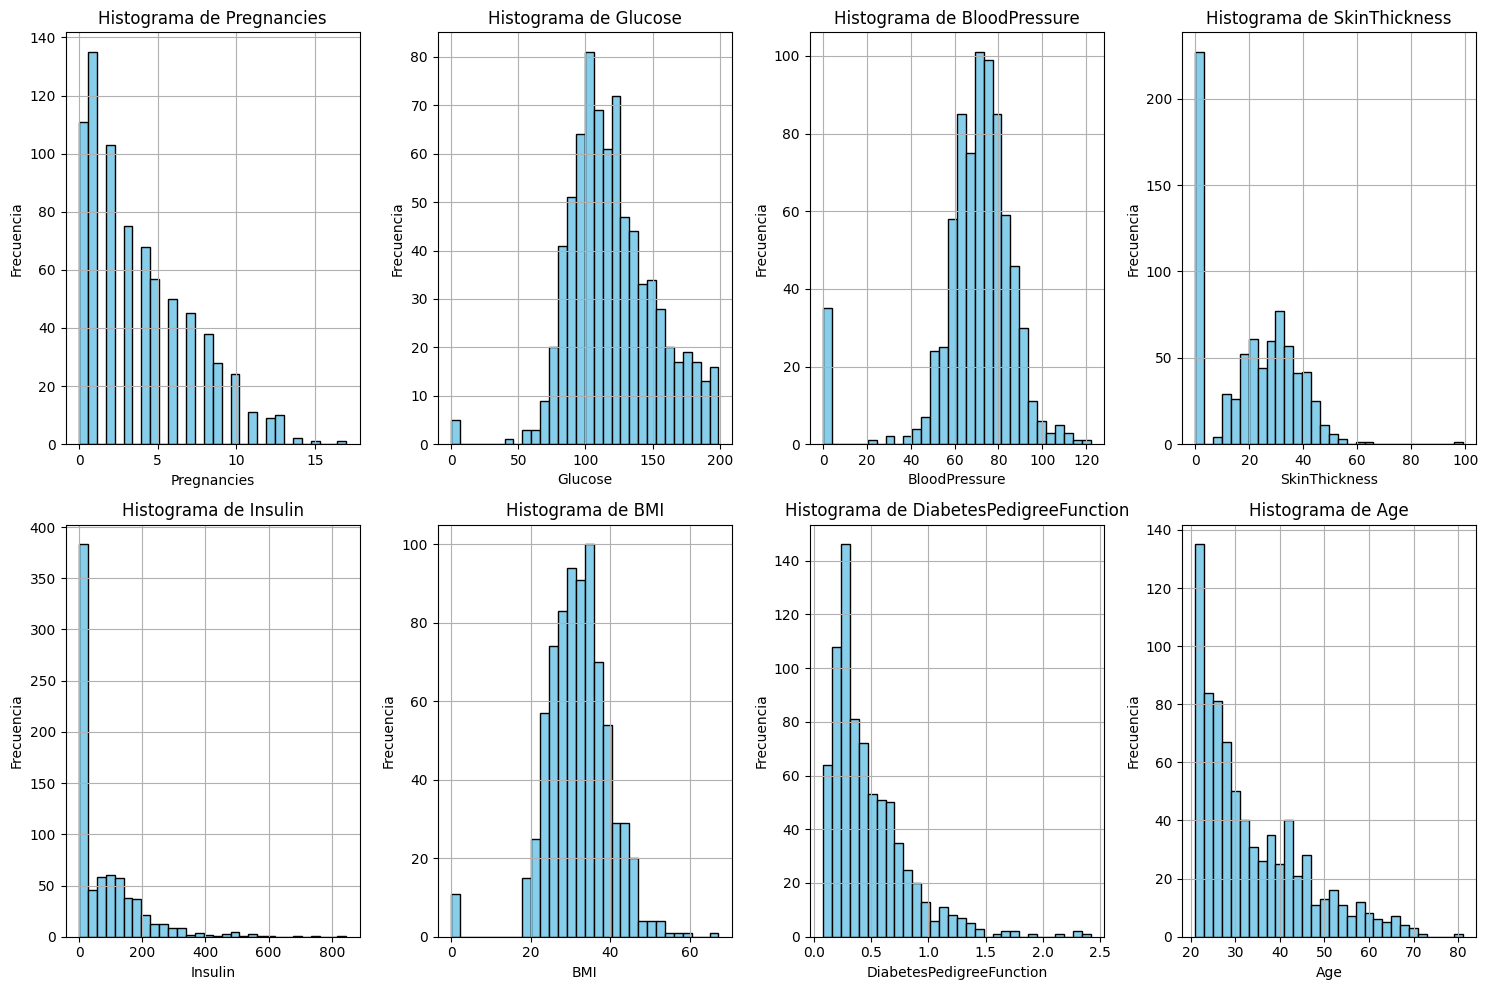

In [36]:
# Histograma para variables numéricas
plt.figure(figsize=(15, 10))  # Establecemos el tamaño de la figura (ancho, alto)
num_plots = len(numerical_cols)  # Contamos el número de columnas numéricas
num_rows = int(np.ceil(num_plots / 4))  # Calculamos el número de filas necesarias para acomodar todos los histogramas (4 columnas por fila)

for i, col in enumerate(numerical_cols, 1):  # Iteramos sobre cada columna numérica y su índice
    plt.subplot(num_rows, 4, i)  # Creamos una subgráfica en la posición (fila, columna)
    df[col].hist(bins=30, color='skyblue', edgecolor='black')  # Dibujamos el histograma de la columna actual
    plt.title(f'Histograma de {col}')  # Establecemos el título del histograma
    plt.xlabel(col)  # Etiquetamos el eje x con el nombre de la columna
    plt.ylabel('Frecuencia')  # Etiquetamos el eje y con 'Frecuencia'

plt.tight_layout()  # Ajustamos la disposición de las subgráficas para que no se superpongan
plt.show() # Mostramos la figura con todos los histogramas


/tmp/ipykernel_22697/1174537663.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=df, palette='Set2')  # creamos el gráfico de barras usando seaborn


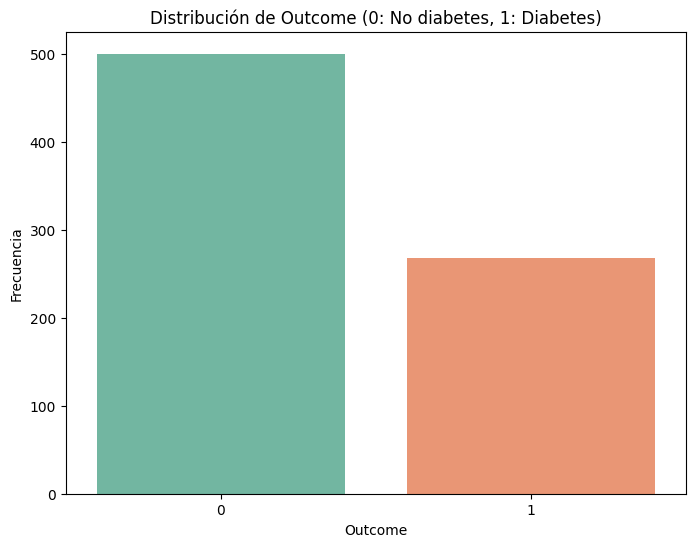

In [37]:
# Gráfico de barras para la variable 'Outcome'
plt.figure(figsize=(8, 6))  # definimos eel tamaño de la figura 8x6
sns.countplot(x='Outcome', data=df, palette='Set2')  # creamos el gráfico de barras usando seaborn
plt.title('Distribución de Outcome (0: No diabetes, 1: Diabetes)')  # definimos el título del gráfico
plt.xlabel('Outcome')  # etiqueta del eje X
plt.ylabel('Frecuencia')  # etiqueta del eje Y
plt.show() # mostramos el grafico

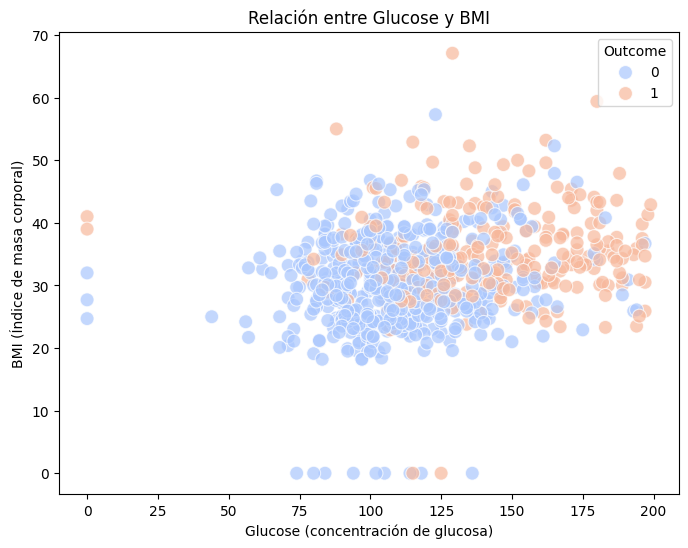

In [38]:
# Diagrama de dispersión entre 'Glucose' y 'BMI'
plt.figure(figsize=(8, 6))  # definimos el tamaño de la figura 8x6
sns.scatterplot(x='Glucose', y='BMI', hue='Outcome', data=df, palette='coolwarm', s=100, alpha=0.7)  # creamos el gráfico de dispersión
plt.title('Relación entre Glucose y BMI')  # definimos el título del gráfico
plt.xlabel('Glucose (concentración de glucosa)')  # etiqueta del eje X
plt.ylabel('BMI (Índice de masa corporal)')  # etiqueta del eje Y
plt.show()  # mostramos el gráfico

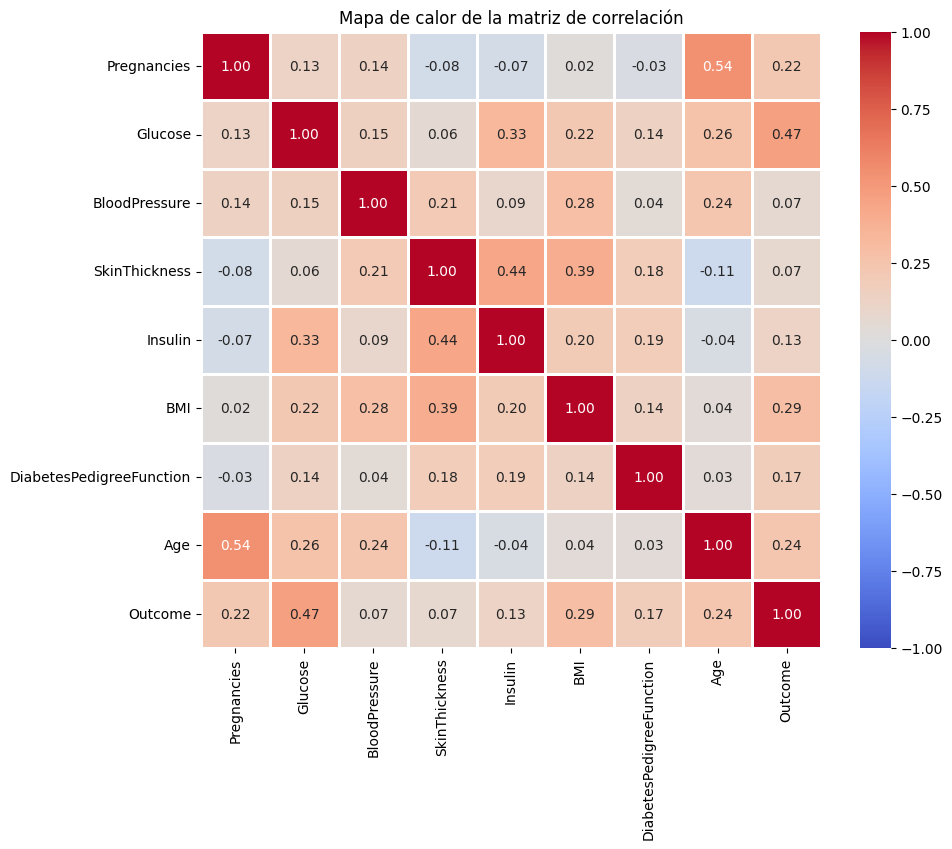

In [39]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()  # calculamos la matriz de correlación para las variables numéricas del DataFrame

# Crear un mapa de calor de las correlaciones
plt.figure(figsize=(10, 8))  # definimos el tamaño de la figura 10x8
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, vmin=-1, vmax=1)  # creamos el mapa de calor
plt.title('Mapa de calor de la matriz de correlación')  # definimos el título del gráfico
plt.show()  # mostramos el gráfico

In [40]:
# Medidas de tendencia central y dispersión para columnas numéricas
media = df[numerical_cols].mean()  # calculamos la media de las columnas numéricas
mediana = df[numerical_cols].median()  # calculamos la mediana de las columnas numéricas
moda = df[numerical_cols].mode().iloc[0]  # calculamos la moda de las columnas numéricas
rango = df[numerical_cols].max() - df[numerical_cols].min()  # calculamos el rango (diferencia entre max y min) de las columnas numéricas
desviacion_estandar = df[numerical_cols].std()  # calculamos la desviación estándar de las columnas numéricas

# Calcular frecuencias y moda para columnas categóricas
frecuencias = df[categorical_cols].apply(pd.value_counts)  # calculamos las frecuencias de las columnas categóricas
moda_categoricas = df[categorical_cols].mode().iloc[0]  # calculamos la moda de las columnas categóricas

# Mostrar los resultados
print("Medidas de tendencia central y dispersión para columnas numéricas:")
print(f"Media:\n{media}\n")  # mostramos la media
print(f"Mediana:\n{mediana}\n")  # mostramos la mediana
print(f"Moda:\n{moda}\n")  # mostramos la moda
print(f"Rango:\n{rango}\n")  # mostramos el rango
print(f"Desviación estándar:\n{desviacion_estandar}\n")  # mostramos la desviación estándar

print("Frecuencias y moda para columnas categóricas:")
print(f"Frecuencias:\n{frecuencias}\n")  # mostramos las frecuencias de las columnas categóricas
print(f"Moda categórica:\n{moda_categoricas}\n")  # mostramos la moda de las columnas categóricas


Medidas de tendencia central y dispersión para columnas numéricas:
Media:
Pregnancies                   3.845052
Glucose                     120.894531
BloodPressure                69.105469
SkinThickness                20.536458
Insulin                      79.799479
BMI                          31.992578
DiabetesPedigreeFunction      0.471876
Age                          33.240885
dtype: float64

Mediana:
Pregnancies                   3.0000
Glucose                     117.0000
BloodPressure                72.0000
SkinThickness                23.0000
Insulin                      30.5000
BMI                          32.0000
DiabetesPedigreeFunction      0.3725
Age                          29.0000
dtype: float64

Moda:
Pregnancies                  1.000
Glucose                     99.000
BloodPressure               70.000
SkinThickness                0.000
Insulin                      0.000
BMI                         32.000
DiabetesPedigreeFunction     0.254
Age                       

/tmp/ipykernel_22697/736425913.py:9: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  frecuencias = df[categorical_cols].apply(pd.value_counts)  # calculamos las frecuencias de las columnas categóricas


In [41]:
df.describe().T # mostramos una estadistica descriptiva para comparar con el calculo anterior

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


### Implementación de Modelos:
* Modelos de Clasificación: Implementa modelos de Random Forest y XGBoost.
* Evaluación de Modelos: Evalúa los modelos utilizando métricas como accuracy, precision, recall, F1-score, y ROC-AUC.
* Comparación de Rendimiento: Compara los resultados de ambos modelos y discute cuál es el más adecuado para este dataset.

In [42]:
# Definir las características (X) y la variable objetivo (y)
X = df.drop(columns='Outcome')  # eliminamos la columna 'Outcome' para definir las características (X)
y = df['Outcome']  # asignamos la columna 'Outcome' como la variable objetivo (y)
# dividimos el dataset en entrenamiento y prueba (75% entrenamiento, 25% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

In [43]:
# creamos un modelo de Random Forest con 100 árboles y un estado aleatorio fijo (42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# entrenamos el modelo con el conjunto de entrenamiento X_train y y_train
rf_model.fit(X_train, y_train)  


RandomForestClassifier(random_state=42)

In [44]:
# creamos el modelo XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# entrenamos el modelo con los datos de entrenamiento
xgb_model.fit(X_train, y_train)

/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:40:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [45]:
# Realizar predicciones en los datos de prueba para ambos modelos
y_pred_rf = rf_model.predict(X_test)  # usamos el modelo Random Forest para predecir las etiquetas del conjunto de prueba (X_test)
y_pred_xgb = xgb_model.predict(X_test)  # usamos el modelo XGBoost para predecir las etiquetas del conjunto de prueba (X_test)

# Exactitud
accuracy_rf = accuracy_score(y_test, y_pred_rf)  # calculamos la precisión del modelo Random Forest comparando las predicciones con los valores reales de y_test
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)  # calculamos la precisión del modelo XGBoost comparando las predicciones con los valores reales de y_test
# Precision
precision_rf = precision_score(y_test, y_pred_rf)  # calculamos la precisión del modelo Random Forest, que mide la proporción de verdaderos positivos entre los positivos predichos
precision_xgb = precision_score(y_test, y_pred_xgb)  # calculamos la precisión del modelo XGBoost, que mide la proporción de verdaderos positivos entre los positivos predichos
# Recall
recall_rf = recall_score(y_test, y_pred_rf)  # calculamos el recall del modelo Random Forest, que mide la proporción de verdaderos positivos entre todos los casos reales positivos
recall_xgb = recall_score(y_test, y_pred_xgb)  # calculamos el recall del modelo XGBoost, que mide la proporción de verdaderos positivos entre todos los casos reales positivos
# F1-Score
f1_rf = f1_score(y_test, y_pred_rf)  # calculamos el F1-Score del modelo Random Forest, que es la media armónica entre precisión y recall
f1_xgb = f1_score(y_test, y_pred_xgb)  # calculamos el F1-Score del modelo XGBoost, que es la media armónica entre precisión y recall
# ROC-AUC
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])  # calculamos el AUC-ROC del modelo Random Forest, que mide el rendimiento del modelo en términos de clasificación binaria
roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])  # calculamos el AUC-ROC del modelo XGBoost, que mide el rendimiento del modelo en términos de clasificación binaria

# Mostrar las métricas
print("Evaluación del modelo Random Forest:")  # imprimimos el encabezado para los resultados de Random Forest
print(f"Accuracy: {accuracy_rf:.4f}")  # mostramos la precisión del modelo Random Forest con 4 decimales
print(f"Precision: {precision_rf:.4f}")  # mostramos la precisión del modelo Random Forest con 4 decimales
print(f"Recall: {recall_rf:.4f}")  # mostramos el recall del modelo Random Forest con 4 decimales
print(f"F1-Score: {f1_rf:.4f}")  # mostramos el F1-Score del modelo Random Forest con 4 decimales
print(f"ROC-AUC: {roc_auc_rf:.4f}\n")  # mostramos el AUC-ROC del modelo Random Forest con 4 decimales

print("Evaluación del modelo XGBoost:")  # imprimimos el encabezado para los resultados de XGBoost
print(f"Accuracy: {accuracy_xgb:.4f}")  # mostramos la precisión del modelo XGBoost con 4 decimales
print(f"Precision: {precision_xgb:.4f}")  # mostramos la precisión del modelo XGBoost con 4 decimales
print(f"Recall: {recall_xgb:.4f}")  # mostramos el recall del modelo XGBoost con 4 decimales
print(f"F1-Score: {f1_xgb:.4f}")  # mostramos el F1-Score del modelo XGBoost con 4 decimales
print(f"ROC-AUC: {roc_auc_xgb:.4f}\n")  # mostramos el AUC-ROC del modelo XGBoost con 4 decimales


Evaluación del modelo Random Forest:
Accuracy: 0.7208
Precision: 0.6071
Recall: 0.6182
F1-Score: 0.6126
ROC-AUC: 0.8120

Evaluación del modelo XGBoost:
Accuracy: 0.7078
Precision: 0.5806
Recall: 0.6545
F1-Score: 0.6154
ROC-AUC: 0.7666



### Comparación de Rendimiento 
* Random Forest tiene un accuracy ligeramente mayor, tiene una precision superior, tiene un mejor ROC-AUC.
* XGBoost tiene un recall superior, F1-Score ligeramente superior.


* El modelo recomendado es Random Forest, ya que tiene una mayor precisión.

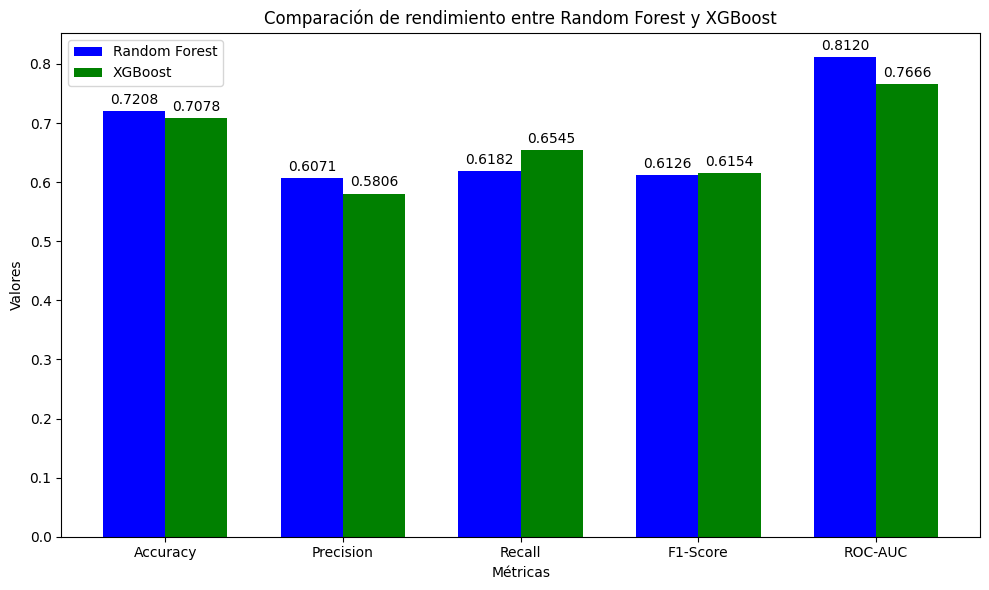

In [46]:
# graficamos para visualizar la comparacion del rendimiento

# Valores de las métricas para ambos modelos
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']  # definimos una lista con los nombres de las métricas que compararemos

rf_scores = [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf]  # asignamos los valores de las métricas para el modelo Random Forest
xgb_scores = [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb, roc_auc_xgb]  # asignamos los valores de las métricas para el modelo XGBoost

# Crear el gráfico
x = np.arange(len(metrics))  # el eje x es el índice de las métricas, que se genera automáticamente
width = 0.35  # el ancho de las barras para cada grupo (Random Forest y XGBoost)

fig, ax = plt.subplots(figsize=(10, 6))  # creamos una figura y un eje para el gráfico, con un tamaño de 10x6

# Barras para Random Forest y XGBoost
rects1 = ax.bar(x - width/2, rf_scores, width, label='Random Forest', color='b')  # barras para Random Forest, desplazadas a la izquierda
rects2 = ax.bar(x + width/2, xgb_scores, width, label='XGBoost', color='g')  # barras para XGBoost, desplazadas a la derecha

# Añadir etiquetas, título y personalización
ax.set_xlabel('Métricas')  # etiqueta del eje X, que representa las métricas
ax.set_ylabel('Valores')  # etiqueta del eje Y, que representa los valores de las métricas
ax.set_title('Comparación de rendimiento entre Random Forest y XGBoost')  # título del gráfico
ax.set_xticks(x)  # definimos las posiciones del eje X
ax.set_xticklabels(metrics)  # asignamos las etiquetas de las métricas al eje X
ax.legend()  # mostramos la leyenda para distinguir las barras de Random Forest y XGBoost

# Función para agregar las etiquetas de los valores en las barras
def add_labels(rects):  # definimos una función para agregar etiquetas de los valores en cada barra
    for rect in rects:  # iteramos sobre cada barra
        height = rect.get_height()  # obtenemos la altura de la barra
        ax.annotate(f'{height:.4f}',  # anotamos la altura de la barra con 4 decimales
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # ubicación de la etiqueta en el centro de la barra
                    xytext=(0, 3),  # desplazamos la etiqueta ligeramente hacia arriba
                    textcoords="offset points",  # las coordenadas son relativas al punto de la barra
                    ha='center', va='bottom')  # alineamos la etiqueta horizontal y verticalmente

# Añadir etiquetas a las barras
add_labels(rects1)  # añadimos las etiquetas a las barras de Random Forest
add_labels(rects2)  # añadimos las etiquetas a las barras de XGBoost

# Mostrar el gráfico
plt.tight_layout()  # ajustamos el diseño para evitar que los elementos se sobrepongan
plt.show()  # mostramos el gráfico

